In [7]:
# import library
# ========= choice of library ====
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread,imresize
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [8]:
# input the mnist data
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((60000,28,28,1))
test_batch = np.zeros((10000,28,28,1))

for x in range(len(x_data)):
    train_batch[x,:,:,:] = np.expand_dims(imresize(x_data[x,:,:,0],(28,28)),axis=3)
for x in range(len(y_data)):
    test_batch[x,:,:,:] = np.expand_dims(imresize(y_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


(60000, 28, 28, 1)
255.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
255.0
0.0
(10000, 10)
1.0
0.0


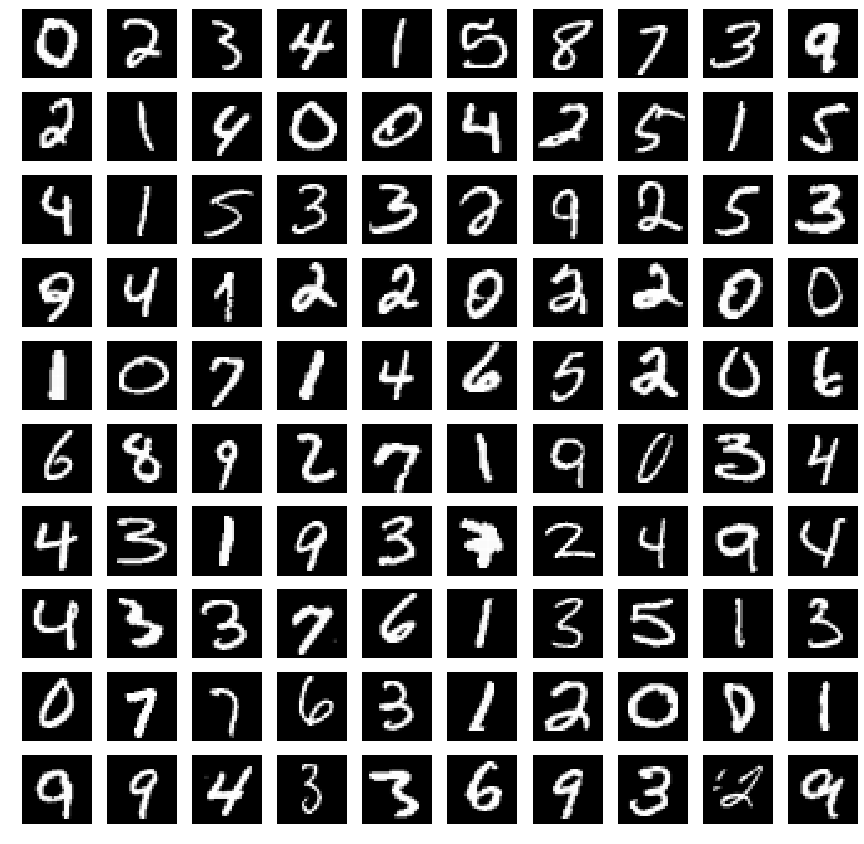

In [9]:
# show random 100 images
idx = np.random.permutation(len(train_batch))
train_batch = train_batch[idx]
fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()

In [11]:
# import all of the layer and needed classes
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float64)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float64) * x) + 1.0)
def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class CNN():

    def __init__(self,k,inc,out,act=tf_elu,d_act=d_tf_elu):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w
    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
        self.layerA = self.act(self.layer)
        return self.layerA
    def backprop(self,gradient,stride=1,padding='SAME',l2_reg = False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        ) / batch_size

        grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
            strides=[1,stride,stride,1],padding=padding
        )
        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

class FNN():
    """Fully Connected Neural Network Implemented in Tensorflow

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.
    special_init : type
        Description of parameter `special_init`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float64,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None,l2_regularization=False):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        if l2_regularization:
            grad = grad + lamda * self.w

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        return grad_pass,update_w    

class FastICA_Layer():
    """Performs ICA via FastICA method

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    sym_decorrelation : type
        Description of attribute `sym_decorrelation`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,matrix : type
        Description of attribute `self,matrix`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.005,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act

    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)

    def getw(self): return self.w

    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass = tf.matmul(tf.transpose(self.w),self.layer)
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - \
                 self.layerDA[:,tf.newaxis] * self.w
        grad_w_dec = self.sym_decorrelation(grad_w)
        update_w = []
        update_w.append(tf.assign(self.w,grad_w_dec))
        return grad_pass,update_w
    
class zca_whiten_layer():
    """ZCA Whiten operation layer.

    Parameters
    ----------
    self) : pass    def feedforward(self
        Description of parameter `self)`.
    input : type
        Description of parameter `input`.
    EPS : type
        Description of parameter `EPS`.

    Attributes
    ----------
    sigma : type
        Description of attribute `sigma`.
    eigenval : type
        Description of attribute `eigenval`.
    eigvector : type
        Description of attribute `eigvector`.
    U : type
        Description of attribute `U`.
    whiten : type
        Description of attribute `whiten`.
    self,grad : type
        Description of attribute `self,grad`.
    input

    """

    def __init__(self): pass

    def feedforward(self,input,EPS=10e-5):
        self.input = input
        self.sigma = tf.matmul(tf.transpose(input),input) / input.shape[0]
        self.eigenval,self.eigvector = tf.linalg.eigh(self.sigma)
        self.U = tf.matmul(tf.matmul(self.eigvector,tf.diag(1./ tf.sqrt(self.eigenval+EPS))),tf.transpose(self.eigvector))
        self.whiten = tf.matmul(input,self.U)
        return self.whiten

    def backprop(self,grad,EPS=10e-5):
        d_U = tf.matmul(tf.transpose(self.input),grad)

        # d_eig_value = self.eigvector.T.dot(d_U).dot(self.eigvector) * (-0.5) * np.diag(1. / (self.eigenval+EPS) ** 1.5)
        d_eig_value = tf.matmul(tf.matmul(tf.transpose(self.eigvector),d_U),self.eigvector)) * (-0.5) * tf.diag(1./(self.eigvector+EPS) ** 1.5 )

        # d_eig_vector = d_U.dot( (np.diag(1. / np.sqrt(self.eigenval+EPS)).dot(self.eigvector.T)).T  ) + (self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval+EPS)))).dot(d_U)

        # ===== tf ===== have to convert to tf
        d_eig_vector = d_U.dot( (np.diag(1. / np.sqrt(self.eigenval+EPS)).dot(self.eigvector.T)).T  ) + (self.eigvector.dot(np.diag(1. / np.sqrt(self.eigenval+EPS)))).dot(d_U)
        E = np.ones((grad.shape[1],1)).dot(np.expand_dims(self.eigenval.T,0)) - np.expand_dims(self.eigenval,1).dot(np.ones((1,grad.shape[1])))
        K_matrix = 1./(E + np.eye(grad.shape[1])) - np.eye(grad.shape[1])
        np.fill_diagonal(d_eig_value,0.0)
        d_sigma = self.eigvector.dot(
                    K_matrix.T * (self.eigvector.T.dot(d_eig_vector)) + d_eig_value
                    ).dot(self.eigvector.T)
        d_x = grad.dot(self.U.T) + (2./grad.shape[0]) * self.input.dot(d_sigma) * 2
        # ===== tf =====

        return d_x

In [34]:
train_batch = train_batch[:1000]
print(train_batch.shape)
# define hyper, class and graph
num_epcoch = 500 ; learning_rate = 0.0001; print_size = 10
batch_size = 100
beta1,beta2,adam_e = 0.9,0.999,1e-8

l1 = CNN(3,1,1)
l2 = CNN(3,1,1)
l3 = CNN(3,1,1)
l_ica = FastICA_Layer(50, 100,act=tf_logcosh,d_act=d_tf_logcosh)

x = tf.placeholder(shape=[batch_size,28,28,1],dtype=tf.float64)
layer1 = l1.feedforward(x)
layer2 = l2.feedforward(layer1)
layer3 = l3.feedforward(layer2)
layer3_flat = tf.reshape(layer3,[batch_size,-1])
layer_ica = l_ica.feedforward(layer3_flat)

just_mean = tf.reduce_mean(layer_ica)

grad_ica,grad_ica_u = l_ica.backprop_ica()
grad_ica_reshape = tf.reshape(grad_ica,[batch_size,28,28,1])
grad_3,grad_3_up = l3.backprop(grad_ica_reshape)
grad_2,grad_2_up = l2.backprop(grad_3)
grad_1,grad_1_up = l1.backprop(grad_2)

grad_update = grad_ica_u + grad_3_up + grad_2_up + grad_1_up

(1000, 28, 28, 1)


In [35]:
# start the interactive session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for iter in range(num_epcoch):
    train_batch = shuffle(train_batch)
    for current_batch_index in range(0,len(train_batch),batch_size):
        current_data = train_batch[current_batch_index:current_batch_index+batch_size]
        sess_results = sess.run([just_mean,grad_update],feed_dict={x:current_data})
        print('iter: ',iter,' index: ', current_batch_index,' mean ',sess_results[0],end='\r')
    if iter > 0 and iter % print_size == 0 :
        print('\n------------\n')

iter:  10  index:  900  mean  -5.4682529079443975e-05
------------

iter:  20  index:  900  mean  -2.4198074190594003e-0617  index:  800  mean  -1.2409268787762668e-05
------------

iter:  30  index:  900  mean  -6.556989234740607e-066600  mean  -1.912241235506779e-06
------------

iter:  40  index:  900  mean  -1.7895021322251823e-05 mean  -1.1357126817325953e-05
------------

iter:  50  index:  900  mean  -2.2896026744103855e-0548  index:  900  mean  -2.2249724921428417e-05
------------

iter:  60  index:  900  mean  -2.7452842513212866e-05 mean  -2.8513565892513102e-05
------------

iter:  70  index:  900  mean  -3.59940661014961e-0555
------------

iter:  80  index:  900  mean  -3.6441590967520626e-05  index:  200  mean  -3.954385753987053e-05
------------

iter:  90  index:  900  mean  -3.731614676207002e-055  index:  500  mean  -3.668938328033196e-05
------------



In [23]:
# view the isolated components
sess_results = sess.run([layer_ica,layer3,layer2,layer1],feed_dict={x:current_data})
for x in sess_results:
    print(x.shape)

(50, 2352)
(100, 28, 28, 3)
(100, 28, 28, 3)
(100, 28, 28, 3)


In [ ]:
# normalize each channel
temp = sess_results[0]
temp = temp.reshape(50,28,28,1)
temp1 = sess_results[1]
temp2 = sess_results[2]
temp3 = sess_results[3]

temp[:,:,:,0] = (temp[:,:,:,0]-temp[:,:,:,0].min())/(temp[:,:,:,0].max()-temp[:,:,:,0].min())
temp[:,:,:,1] = (temp[:,:,:,1]-temp[:,:,:,1].min())/(temp[:,:,:,1].max()-temp[:,:,:,1].min())
temp[:,:,:,2] = (temp[:,:,:,2]-temp[:,:,:,2].min())/(temp[:,:,:,2].max()-temp[:,:,:,2].min())
temp1[:,:,:,0] = (temp1[:,:,:,0]-temp1[:,:,:,0].min())/(temp1[:,:,:,0].max()-temp1[:,:,:,0].min())
temp1[:,:,:,1] = (temp1[:,:,:,1]-temp1[:,:,:,1].min())/(temp1[:,:,:,1].max()-temp1[:,:,:,1].min())
temp1[:,:,:,2] = (temp1[:,:,:,2]-temp1[:,:,:,2].min())/(temp1[:,:,:,2].max()-temp1[:,:,:,2].min())

temp2[:,:,:,0] = (temp2[:,:,:,0]-temp2[:,:,:,0].min())/(temp2[:,:,:,0].max()-temp2[:,:,:,0].min())
temp2[:,:,:,1] = (temp2[:,:,:,1]-temp2[:,:,:,1].min())/(temp2[:,:,:,1].max()-temp2[:,:,:,1].min())
temp2[:,:,:,2] = (temp2[:,:,:,2]-temp2[:,:,:,2].min())/(temp2[:,:,:,2].max()-temp2[:,:,:,2].min())

temp3[:,:,:,0] = (temp3[:,:,:,0]-temp3[:,:,:,0].min())/(temp3[:,:,:,0].max()-temp3[:,:,:,0].min())
temp3[:,:,:,1] = (temp3[:,:,:,1]-temp3[:,:,:,1].min())/(temp3[:,:,:,1].max()-temp3[:,:,:,1].min())
temp3[:,:,:,2] = (temp3[:,:,:,2]-temp3[:,:,:,2].min())/(temp3[:,:,:,2].max()-temp3[:,:,:,2].min())
print(temp.shape)
print(temp1.shape)
print(temp2.shape)
print(temp3.shape)

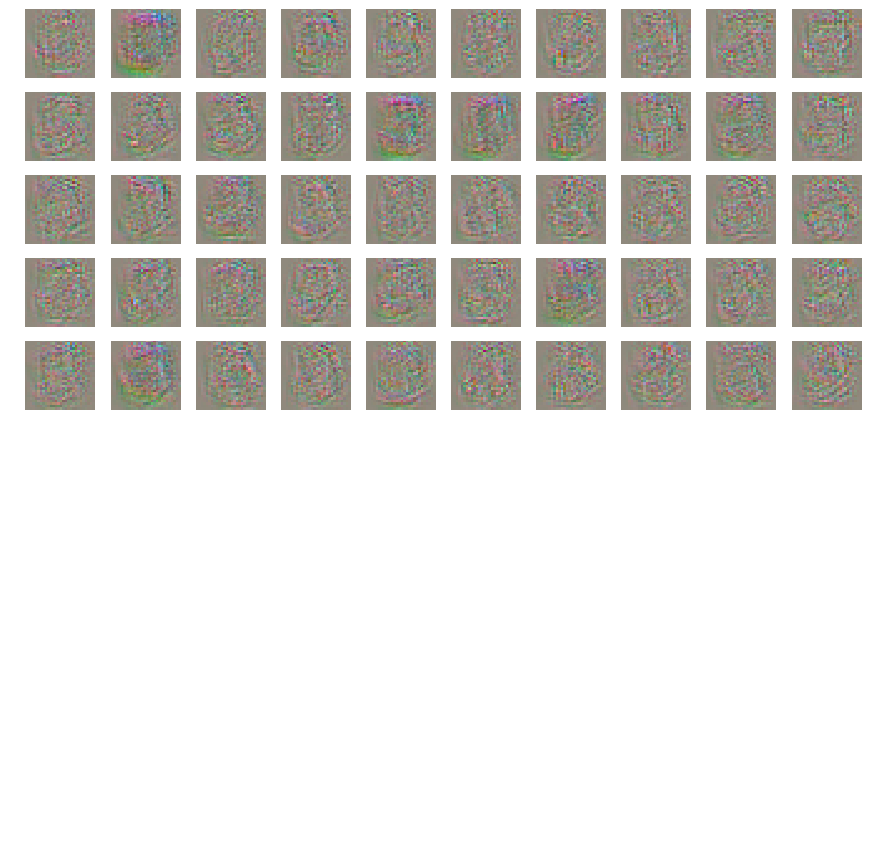

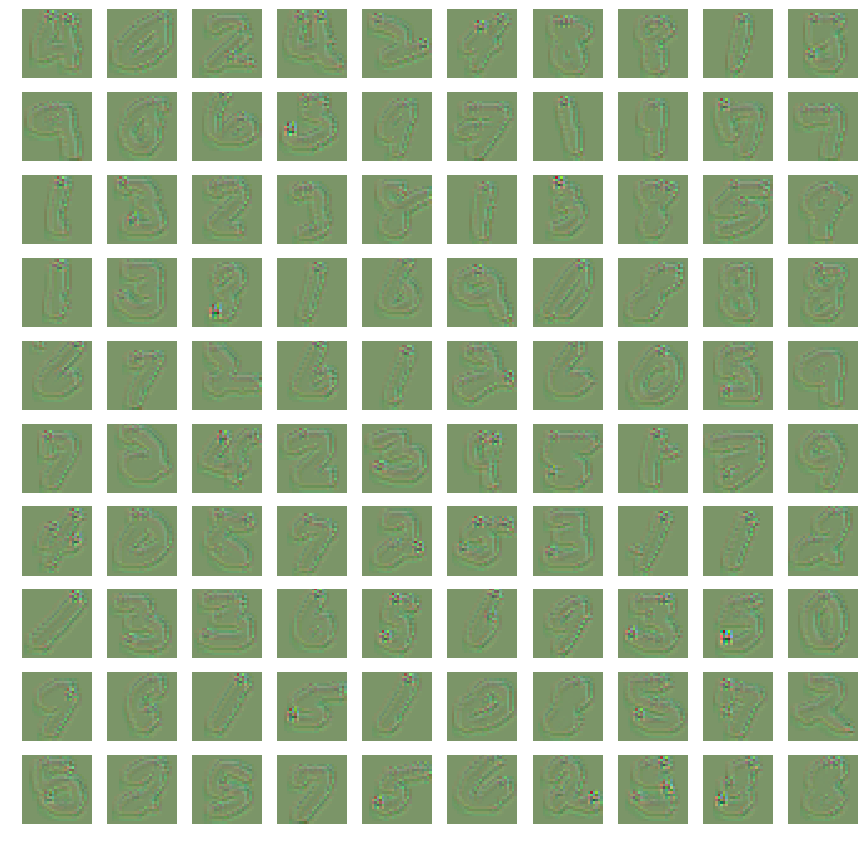

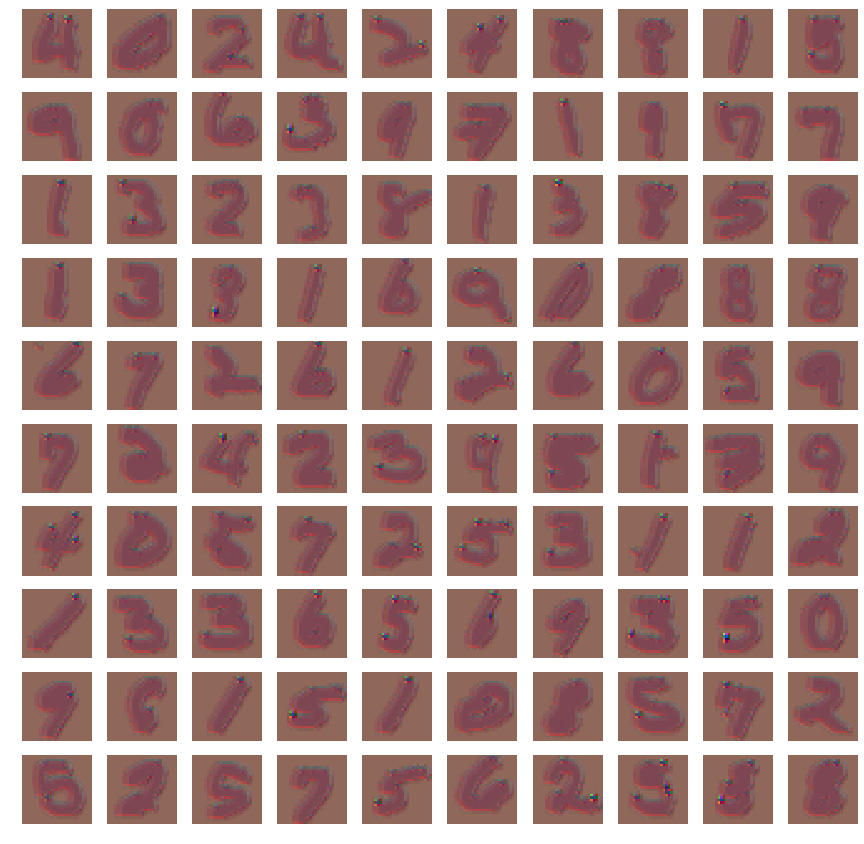

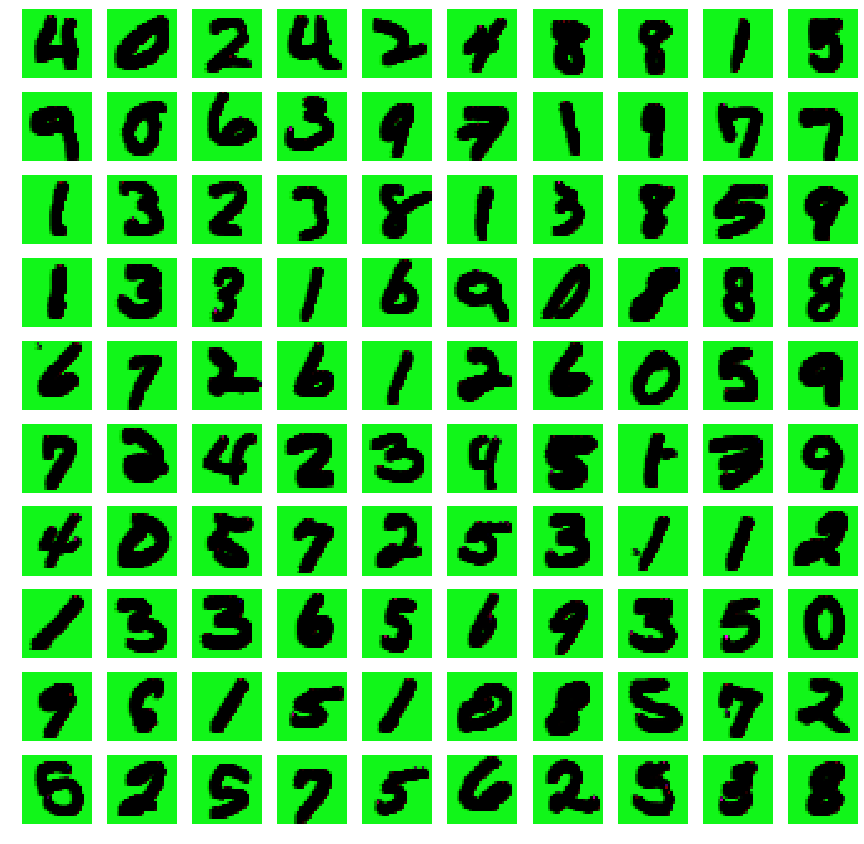

In [29]:
# show each components

fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(temp[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
plt.show()


fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(temp1[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
plt.show()


fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(temp2[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
plt.show()


fig=plt.figure(figsize=(15, 15))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(np.squeeze(temp3[i-1]),cmap='gray')
    except:
        pass
    plt.axis('off')
plt.show()

In [31]:
! git all-go

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
